## Background

---

Discrete Event Simulation (DES) is a useful decision making tool that can be applied to situations where resources are limited and queues exists in the process or system. Using DES, stakeholders can assess the outcomes, measured by specified Key Point Indicators (KPIs), of various scenarios (e.g. different bed capacities or staffing schedules in a clinic) without having to conduct experiments onsite (read more about DES itself [here](https://www.sciencedirect.com/topics/engineering/discrete-event-simulation)). Nowadays, there are many softwares that enable not only simulations but also animations of systems and processes. However, in this notebook, we will take a look at a process-based discrete event simulation framework within Python called SimPy. The notebook is divided into two main sections. In the first part, we will take a look at the basic functionalities of SimPy with a simple emergency room (ER) example; in the second half, we will witness the real power of SimPy through object-oriented programming. Through this notebook, we hope to give you some basic ideas of what some of the software package is doing behind the scene.

Before we begin, please install and import the following packages (if you are running the notebook on Syzygy, you might still need to "pip install" the `simpy` package by opening a terminal in the virtual evironment):

In [1]:
import simpy as sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import timedelta

## Process-Oriented Modeling

---

Let's start by building a simple process model. Let's assume the following for an ER:

- There is only one required resource for each patient: a bed (tied to a doctor)
- There is only one bed (and doctor) in the ER
- The ER opens 24/7 (and we will only simulate the first 24 hours)
- The first patient arrives at exactly 12am (midnight)
- After that, approximately 2 patients arrive every hour (which can be modeled with an exponential distribution)
- Each patient uses the bed for approximately 30 minutes (which can also be fitted with an exponential distribution)
- The patient will always survive if they get to use the bed (see the doctor), but on average they can survive for 10 minutes while waiting (which again can be modeled with an exponential distribution)

First, we will assign the above information to variables so that our code could be more dynamic for the future:

In [2]:
cap_bed = 1.0
avg_arr = 2.0 # patients per hour
avg_bed_use = 0.5 # hour per patient
surv_time = 1/6 
sim_time = 24.0

In the package SimPy, simulations are conducted within an `environment`. It would be more convenient to initiate the `environment` right before running the model, after all the resources and processes are defined; however, we will keep this at the beginning for the first half of this notebook so that everyone knows what the variable `env` refers to later on in the various `functions` that we define.

In [10]:
env = sim.Environment()

After the environment is initiated, we can create within the `environment` our `resource`: bed

In [11]:
bed = sim.Resource(env, capacity=cap_bed)

In more complicated discrete simulation models, one would usually need to utilize Python `class` (read more about Python `class` [here](https://docs.python.org/3/tutorial/classes.html)). However, we are only going to define `function` in the first half for simplicity, and we will create `classes` later when we move into the second section.

In the first function, `arrival`, which we are going to define below, we want the user to pass in three arguments: the `environment` of this particular simulation, the average number of patient arrivals per hour, and the resource needed for each patient. As long as the simulation is still running, this function will continue to operate. The function contains `yield` instead of `return`, which allows it to be come a `generator` (read more about Python `generators` [here](https://wiki.python.org/moin/Generators). Every time a patient variable (object) is created through this function, the environment is progressed for the randomly simulated amount of interrival time.

In [12]:
def arrival(env, avg_arr, bed):
    i = 1
    while True:
        p = patient(env, 'Patient {:02d}'.format(i), bed, avg_bed_use)
        env.process(p)
        t = np.random.exponential(1/avg_arr)
        i += 1
        yield env.timeout(t)

The second function, `patient`, takes in four arguments: the `environment`, the patient's identification number, the required resource (bed), and the average amount of time each patient uses the bed. Within the function, we first record the arrival time of the patient, and then we request for the resource, bed, using the `request()` method. The environment is going to progress either until the resource becomes available or until the patient runs out of his/her 'survival time'. After calculating the wait time, if the patient is still alive, we progress the environment for the patient's diagnosis time.

In [13]:
def patient(env, patient_id, bed, avg_bed_use):
    
    arrive = env.now
    print('{}: {} arrived'.format(str(timedelta(hours=round(env.now,2))), patient_id))
    
    with bed.request() as req:
        survival = np.random.exponential(surv_time)
        # Wait till either the resource to become available
        # or the end of the patient's survival time, whichever first
        results = yield req | env.timeout(survival)
        
        wait = env.now - arrive
        
        if req in results:
            print('{}: {} waited for {}'.format(str(timedelta(hours=round(env.now,2))), 
                                                patient_id, 
                                                str(timedelta(hours=round(wait,2)))))
            
            diagnosis = np.random.exponential(avg_bed_use)
            yield env.timeout(diagnosis)
            print('{}: {} is discharged'.format(str(timedelta(hours=round(env.now,2))), patient_id))
        
        else:
            print('{}: {} left us after {}, unfortunately'.format(str(timedelta(hours=round(env.now,2))),
                                                                  patient_id,
                                                                  str(timedelta(hours=round(wait,2)))))

After we set up the function that we need for the simulation, we then have load them into our environment by using the `process()` method (read about [SimPy `processes`](https://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html)). Finally, we can start the simulation using the `run()` method:

In [14]:
env.process(arrival(env, avg_arr, bed))
env.run(until=sim_time)

0:00:00: Patient 01 arrived
0:00:00: Patient 01 waited for 0:00:00
0:08:24: Patient 01 is discharged
0:24:36: Patient 02 arrived
0:24:36: Patient 02 waited for 0:00:00
0:40:12: Patient 02 is discharged
0:48:36: Patient 03 arrived
0:48:36: Patient 03 waited for 0:00:00
1:06:00: Patient 03 is discharged
1:10:12: Patient 04 arrived
1:10:12: Patient 04 waited for 0:00:00
1:22:48: Patient 05 arrived
1:23:24: Patient 04 is discharged
1:23:24: Patient 05 waited for 0:01:12
2:33:00: Patient 06 arrived
2:37:12: Patient 06 left us after 0:04:12, unfortunately
2:53:24: Patient 07 arrived
2:59:24: Patient 07 left us after 0:06:00, unfortunately
3:08:24: Patient 08 arrived
3:11:24: Patient 08 left us after 0:03:00, unfortunately
3:17:24: Patient 09 arrived
3:21:00: Patient 09 left us after 0:03:36, unfortunately
3:45:00: Patient 05 is discharged
3:46:48: Patient 10 arrived
3:46:48: Patient 10 waited for 0:00:00
4:08:24: Patient 11 arrived
4:20:24: Patient 11 left us after 0:12:36, unfortunately
4:2

In SimPy, simulation normally starts at time 0 unless specified. Time is also unit-less within SimPy, so we can define it however we want, though it is best to keep it consistent to avoid confusion. In the function above, we re-formatted the unitless time by passing it into a `timedelta()` function as hours, and displayed it after transforming it into a string using the `str()` function.

## Object-Oriented Modeling

---

Ta-da! We just ran our first SimPy simulation. However, you probably have noticed right away that:

1. The output is long and not very readable even for such a simple simulation
2. If we create more functions for a more complicated simulation, each function can easily get lost in the code

In the this scenario, we are going to use `classes` and `methods` to separate the different processes and objects/entities; we will also visualize a couple of key point indicators (KPIs) so that the simulation results are more interpretable. `Classes` also help us better organize the different methods (functions) by giving it more structure. Our situation description stays the same:

- There is only one required resource for each patient: a bed (tied to a doctor)
- There is only one bed (and doctor) in the ER
- The ER opens 24/7 (and we will only simulate the first 24 hours)
- The first patient arrives at exactly 12am (midnight)
- After that, approximately 2 patients arrive every hour (which can be modeled with an exponential distribution)
- Each patient uses the bed for approximately 30 minutes (which can also be fitted with an exponential distribution)
- The patient will always survive if they get to use the bed (see the doctor), but on average they can survive for 10 minutes while waiting (which again can be modeled with an exponential distribution)

In [15]:
cap_bed = 1.0
avg_arr = 2.0 # patients per hour
surv_time = 1/6
avg_bed_use = 0.5 # hour per patient
sim_time = 24.0

In this scenario, we will define four `classes`: Record, Patient, Bed (Resource), and Model. The Record class is simply created to (you guessed it) store global variables and performance metrics of the simulation:

In [31]:
class Record:
    
    # the frequency that we are going to check our simulation
    check_interval = 0.25 
    
    # storage space for KPIs at each check point
    check_time = []
    check_pat_current = [] # total current patients
    check_pat_waiting = [] # current patients waiting
    check_bed_inuse = [] # current number of bed in use
    check_survival = [] # current survival rate
    
    # storage space for each patient's timeline
    record_pat_id = []
    record_time_in = [] 
    record_wait_time = []
    record_time_use_bed = [] # the time when each patient starts using the bed
    record_bed_use = [] # the amount of time each patient uses the bed
    record_time_out = []
    record_survival = [] # binary variable indicating whether the patient survived
    
    # global variables
    count_pat = 0 # total patients throughout the simulation
    pat_waiting = 0 # current number of patients waiting
    pat_current = 0 # total current patients
    survival = 0 # total number of patients who survived
    
    # empty dataframes created for visualization
    results = pd.DataFrame()
    history = pd.DataFrame()

The second and third classes, `Patient` and `Bed`, are also quite simple. The `Patient` class starts with a dictionary that stores all the patients (which are python objects); it then initiates a list of attributes for itself. The `Bed` class simply set up a resource with the designated capacity.

In [32]:
class Patient:
    
    all_patients = {}
    
    def __init__(self, env):
        Record.count_pat += 1
        #attributes
        self.id = Record.count_pat
        self.bed_use = np.random.exponential(avg_bed_use) # the amount of time this patient will use the bed
        self.time_in = env.now # arrival time
        self.time_queue = 0.0 # wait time
        self.time_use_bed = 0.0 # time when this patient starts using the bed
        self.time_out = 0.0 # time when the patient gets discharged
        self.surv_time = np.random.exponential(surv_time) # the amount of time the patient can survive waiting
        self.survival = 1 # binary variable indicating whether this patient survives
        
class Bed:
    
    def __init__(self, env, cap_bed):
        self.bed = sim.Resource(env, capacity=cap_bed)  

The `Model` class seem to be a lot more complicated, but we can disect it by looking at each of its methods (which would normally be called functions had they not been included under a class). 

- First, an environment is initiated whenever this class is called
- The second method, `use_bed()`, defines the process of requesting for a resource; after requesting for the bed, we record the patient into our global variables and simulate a random survival time for him/her. It then goes through the same process as described in the first half of this notebook, simulating and recording the each patient's attributes such as wait time and survival status
- The `patient_arrival()` method generates `Patient` python objects as long as the simulation is running, progressing the environment by a randomly simulated inter-arrival time each time a patient is generated
- The `check_model()` method is a parallel process to the `patient_arrival()` process, which checks on the global variables in specified intervals (defined in `Record` class)
- The `run()` method (you guessed it again) loads the two parallel processes and initializes the entire simulation process
- The `build_report()` and `plot_results()` methods generates visualized representations of the simulation at the end of each run

In [33]:
class Model:
    
    def __init__(self):
        
        self.env = sim.Environment()
    
    def use_bed(self, pat):
        
        with self.resource_bed.bed.request() as req:
            
            Record.pat_waiting += 1
            Record.pat_current += 1
            
            results = yield req | self.env.timeout(pat.surv_time)
            
            pat.time_use_bed = self.env.now
            pat.time_queue = self.env.now - pat.time_in
            Record.pat_waiting -= 1
            
            if req in results:

                yield self.env.timeout(pat.bed_use)
                pat.time_out = self.env.now
                pat.survival = 1
                Record.pat_current -= 1
                Record.survival += 1
            
            else:
                
                pat.bed_use = 0.0
                pat.time_out = 0.0
                pat.survival = 0
                Record.pat_current -= 1
                
            Record.record_pat_id.append(pat.id)
            Record.record_time_in.append(pat.time_in)
            Record.record_wait_time.append(pat.time_queue)
            Record.record_time_use_bed.append(pat.time_use_bed)
            Record.record_bed_use.append(pat.bed_use)
            Record.record_time_out.append(pat.time_out)
            Record.record_survival.append(pat.survival)
            
    def patient_arrival(self):
        
        while self.env.now < sim_time:
            
            pat = Patient(self.env)
            pat.all_patients[pat.id] = pat
            self.env.process(self.use_bed(pat))
            
            pat_arr_next = np.random.exponential(1/avg_arr)
            yield self.env.timeout(pat_arr_next)
            
    def check_model(self):
        
        while True:
            
            Record.check_time.append(self.env.now)
            Record.check_pat_waiting.append(Record.pat_waiting)
            Record.check_pat_current.append(Record.pat_current)
            Record.check_survival.append(Record.survival/Record.count_pat)
            Record.check_bed_inuse.append(self.resource_bed.bed.count)
            yield self.env.timeout(Record.check_interval)
            
    def run(self):
        
        self.resource_bed = Bed(self.env, cap_bed)
        
        self.env.process(self.patient_arrival())
        self.env.process(self.check_model())
        self.env.run(until=24.0)
        
        self.build_report()
        self.plot_results()
    
    def build_report(self):
        
        Record.results['Time'] = Record.check_time
        Record.results['Current Patients'] = Record.check_pat_current
        Record.results['Waiting Patients'] = Record.check_pat_waiting
        Record.results['Bed in Use'] = Record.check_bed_inuse
        
        Record.history['Patient ID'] = Record.record_pat_id
        Record.history['Time In'] = Record.record_time_in
        Record.history['Wait Time'] = Record.record_wait_time
        Record.history['Bed Start'] = Record.record_time_use_bed
        Record.history['Use Time'] = Record.record_bed_use
        Record.history['Time Out'] = Record.record_time_out
        Record.history['Survival'] = Record.record_survival
        
    def plot_results(self):
        
        fig, ax = plt.subplots(2, 2, figsize=(9,8), dpi=100)
        
        x = Record.record_pat_id
        y = Record.record_wait_time
        ax[0,0].scatter(x, y, marker='x')
        ax[0,0].set_xlabel('Patient ID')
        ax[0,0].set_ylabel('Wait Time')
        ax[0,0].set_title('Wait Time of Each Patient')
        ax[0,0].grid(True, which='both', lw=1, ls='--', c='.75')
        ax[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        x = Record.check_time
        y = Record.check_pat_waiting
        ax[0,1].plot(x, y, marker='.')
        ax[0,1].set_xlabel('Time')
        ax[0,1].set_ylabel('Patients Waiting')
        ax[0,1].set_title('Patients Waiting at Each Check Point')
        ax[0,1].grid(True, which='both', lw=1, ls='--', c='.75')
        
        x = Record.check_time
        y = Record.check_bed_inuse
        ax[1,0].plot(x, y, marker='.')
        ax[1,0].set_xlabel('Time')
        ax[1,0].set_ylabel('Bed In Use')
        ax[1,0].set_title('Bed In Use at Each Check Point')
        ax[1,0].grid(True, which='both', lw=1, ls='--', c='.75')
        
        x = Record.check_time
        y = Record.check_survival
        ax[1,1].plot(x, y, marker='.', color='red')
        ax[1,1].set_xlabel('Time')
        ax[1,1].set_ylabel('Survival Rate')
        ax[1,1].set_title('Survival Rate at Each Check Point')
        ax[1,1].grid(True, which='both', lw=1, ls='--', c='.75')
        
        plt.tight_layout(pad=3)
        plt.show()

Now we have finished defining the classes and their methods, we can finally create an instance of the model and run it!

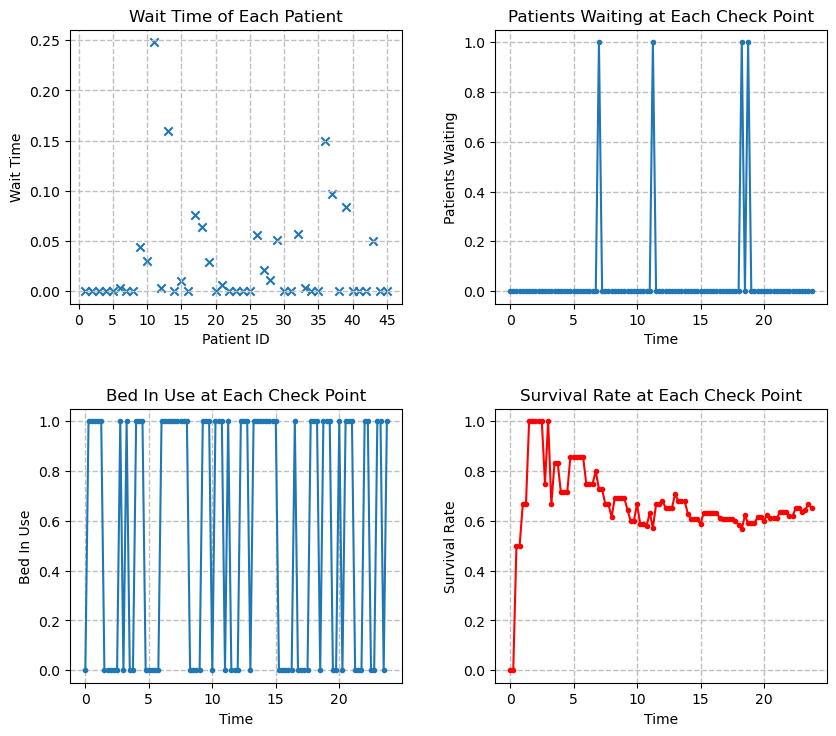

In [34]:
np.random.seed(0) #https://numpy.org/devdocs/reference/random/generated/numpy.random.seed.html
model = Model()
model.run()

In [37]:
display(round(Record.history.describe()[['Wait Time', 'Use Time', 'Survival']].drop('count', axis=0),2))

,Wait Time,Use Time,Survival
mean,0.03,0.29,0.67
std,0.05,0.41,0.48
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.09,1.00
75%,0.04,0.44,1.00
max,0.25,1.88,1.00


We can see that the survival rate stabilizes to around 60% after around 7 or 8 hours, which is something that you should explore, depending on whether you are running Finite-Horizon or Infinite-Horizon DES. Nevertheless, it could be suprising to some that even though under the given conditions, where around 2 patients arrive per hour and each patient uses the bed for approximately 30 minutes, there seems to be high utilization of the bed and long wait time for patients. Simulation is extremely helpful when there is uncertainties, especially in cases like this, where the given condition seems to be reasonable, but actually lead to disastrous outputs. Below is a detailed list of each patient's record:

In [38]:
time_history = Record.history.copy()

time_history[['Time In', 
              'Wait Time', 
              'Bed Start', 
              'Use Time', 
              'Time Out']]=time_history[['Time In', 
                                         'Wait Time', 
                                         'Bed Start', 
                                         'Use Time', 
                                         'Time Out']].apply(lambda x: pd.to_timedelta(round(x,2), unit='h'))

display(time_history)

,Patient ID,Time In,Wait Time,Bed Start,Use Time,Time Out,Survival
0,1,00:00:00,00:00:00,00:00:00,00:24:00,00:24:00,1
1,2,00:27:36,00:00:00,00:27:36,00:23:24,00:51:36,1
2,3,00:58:48,00:00:00,00:58:48,00:17:23.999999,01:16:12,1
3,4,02:38:24,00:00:00,02:38:24,00:14:24,02:52:48,1
4,6,03:03:00,00:00:00,03:03:00,00:00:00,00:00:00,0
5,5,03:00:36,00:00:00,03:00:36,00:25:12,03:25:48,1
6,7,03:57:00,00:00:00,03:57:00,00:45:00,04:42:00,1
7,8,05:52:12,00:00:00,05:52:12,00:48:00,06:40:12,1
8,9,06:37:48,00:02:24,06:40:12,00:03:36,06:43:48,1
9,11,06:58:12,00:15:00,07:13:12,00:00:00,00:00:00,0


## Next Steps

---

Now that you have a basic understanding of how to build a simple Discrete Event Simulation model using SimPy, we encourage to take it one step further and find out the business implications of the following:

1. What is the most optimal number of beds in this simulation? You might want to make different assumptions about the cost of each bed/doctors
2. Can you conduct sensitivity analysis and see the impact from changes on some of the existing assumptions such as:
  - The inter-arrival time of patients
  - The amount of time each patient uses the bed
  - Each patient's survival time (or probability) while waiting and after they see a doctor